In [3]:
import jax
from tinygp import kernels
from tinygp import GaussianProcess

import numpy as np
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

In [4]:
kernel = 0.5 * kernels.ExpSquared(scale=1.5)
DESI_2024_sigmaz_corr_pzbin1 = np.load('data/Fig1_Fig8_dr10_allfoot_perbin_sigmaz0.0500_dr6_corr_pzbin1.npz')

X=DESI_2024_sigmaz_corr_pzbin1['theta_arcmins']
y=DESI_2024_sigmaz_corr_pzbin1['prof']

gp = GaussianProcess(kernel, X, diag=1e-4)


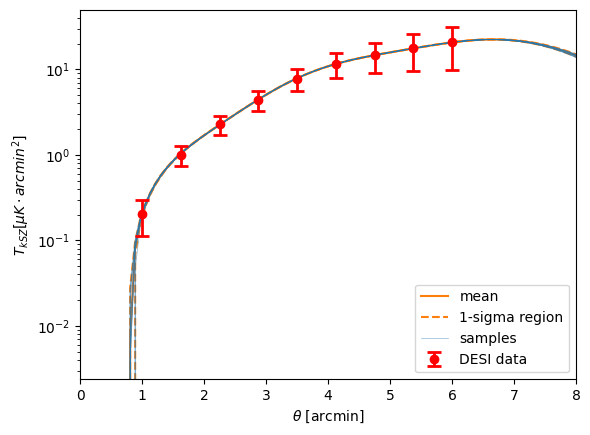

In [7]:
X_test = np.linspace(0, 8, 100)
_, cond_gp = gp.condition(y, X_test)

# The GP object keeps track of its mean and variance, which we can use for
# plotting confidence intervals
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)
plt.plot(X_test, mu, "C1", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)

plt.errorbar(DESI_2024_sigmaz_corr_pzbin1['theta_arcmins'], DESI_2024_sigmaz_corr_pzbin1['prof'], yerr=np.sqrt(DESI_2024_sigmaz_corr_pzbin1['cov'].diagonal()), color='r',
             fmt='o',capsize=5, capthick=2, linewidth=2, markersize=6, label="DESI data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())

plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$T_{kSZ} [\mu K \cdot arcmin^2]$')
plt.yscale('log')
plt.show()

# TRAINING...!

## Hyperparameter optimization for GP on mean profiles
- 2-Stage robust training: ✅ proved faster and same accuracy 
- find best kernel 
- make sure GPTrainer() runs ✅ 
- if kSZ data, only train on first 10 bins (R<3 Mpc)
- Pk only use k<10c/Mpc: ✅  no change and faster 
- train with or without validation data

In [1]:
import importlib
import src.models.kernels
importlib.reload(src.models.kernels) 
from src.models.kernels import *
import src.data.sim_dataloader
importlib.reload(src.data.sim_dataloader) 
import src.models.gp_trainer
importlib.reload(src.models.gp_trainer) 
from src.models.gp_trainer import *

# Initialize trainer with simulation indices and configuration
trainer = GPTrainer(
    sim_indices_total=np.arange(1024).tolist(),
    train_test_val_split=(0.7, 0.2, 0.1),
    filterType='CAP',
    ptype='gas'
)



/global/u1/l/lindajin/virtualenvs/env1/lib/python3.11/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.6.1 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


JAX devices: [CpuDevice(id=0)]
Using device: TFRT_CPU_0
JAX devices: [CpuDevice(id=0)]
Using device: TFRT_CPU_0
JAX devices: [CpuDevice(id=0)]
Using device: TFRT_CPU_0
GPTrainer initialized:
  - Total sims: 1024
  - Filter: CAP, Particle: gas
  - Save dir: /pscratch/sd/l/lindajin/DH_profile_kSZ_WL/trained_gp_models/GPTrainer_091025_2209_CAP_gas
Loading training data...
Loading data for 1024 simulations...
Getting mean gas profiles with CAP filter for 1024 simulations...
Finished getting mean profiles from 1024 simulations.
Output shape: (1024, 21) vs individual halo shape would be (n_halos*1024, 21)
Raw data loaded:
  - Profiles: (1024, 21)
  - Masses: (1024,)
  - Params: (1024, 35)
  - PkRatio: (1024, 79)
Applying data transformations...
Log mass range: [12.70, 14.53]
✅ Features normalized (zero mean, unit variance)
Final data shapes:
  - Features: (1024, 115)
  - Targets: (1024, 21)
Creating train/validation/test splits...
Split created:
  - Train: 716 samples (69.9%)
  - Val:   102 


=== Training GP with physics_informed kernel ===
Training 21 GP models...


Training GP models: 100%|██████████| 21/21 [22:28<00:00, 64.21s/it]


Training completed in 1348.5s


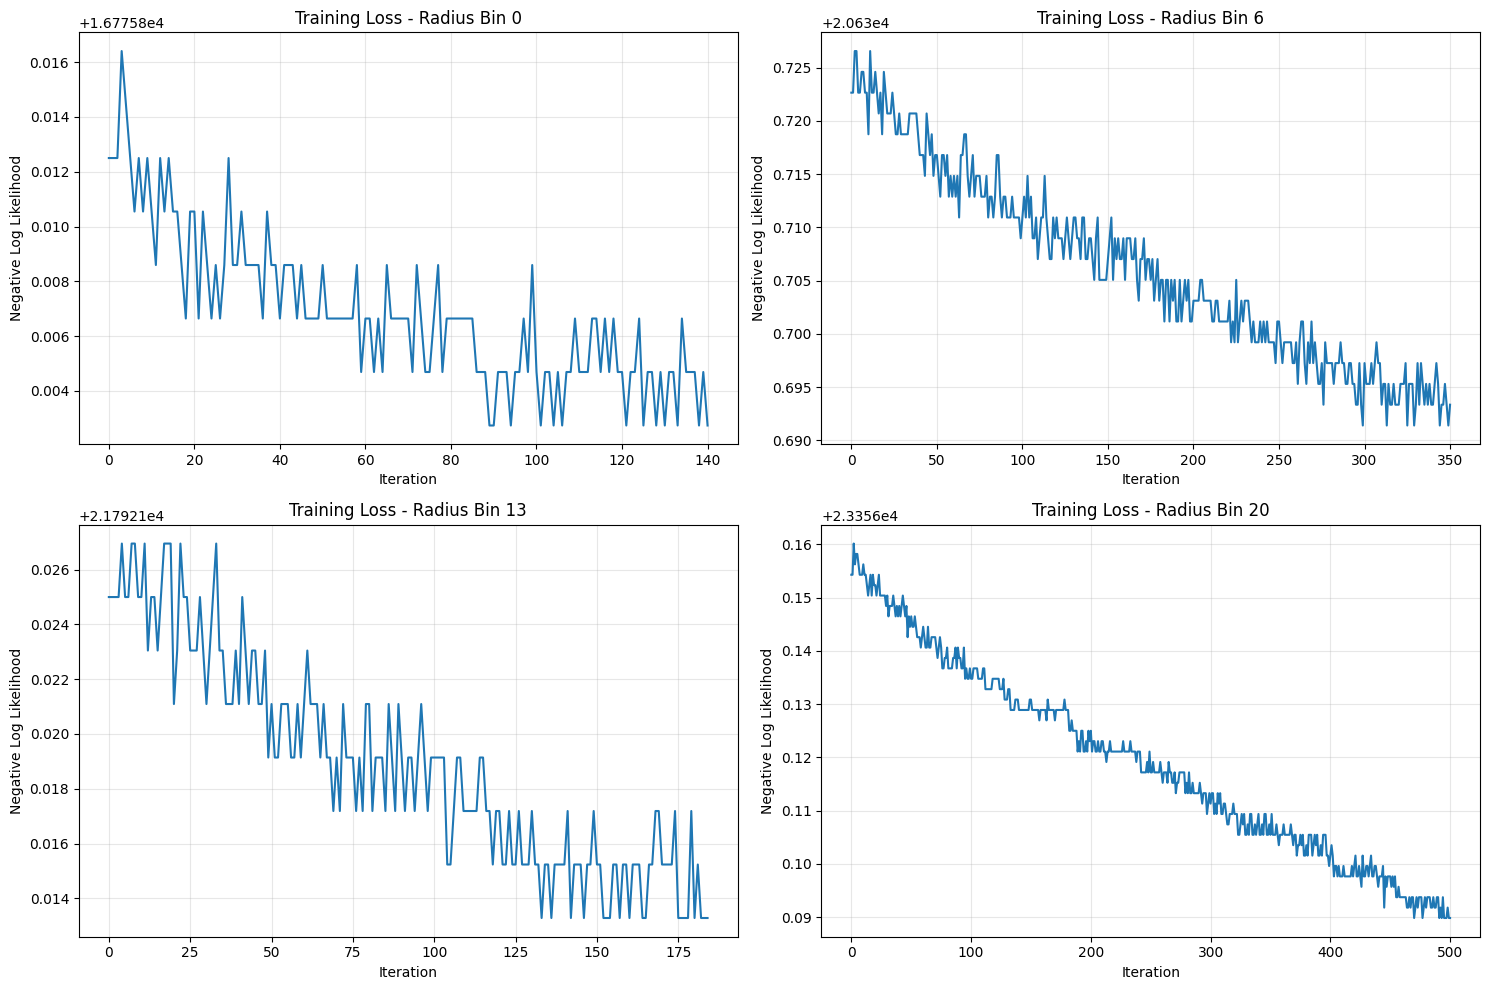

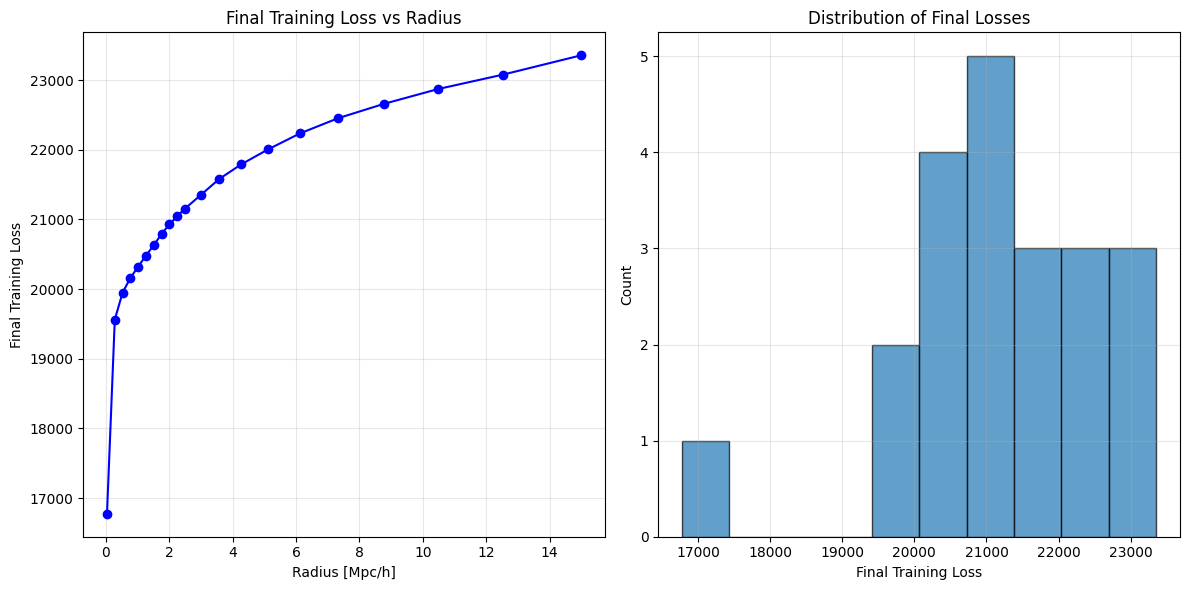

Models saved to /pscratch/sd/l/lindajin/DH_profile_kSZ_WL/trained_gp_models/GPTrainer_091025_2209_CAP_gas/

=== Testing GP Models ===
Evaluating on test set...
Generating predictions...


Predicting: 100%|██████████| 21/21 [00:05<00:00,  3.90it/s]


Predictions generated in 5.4s


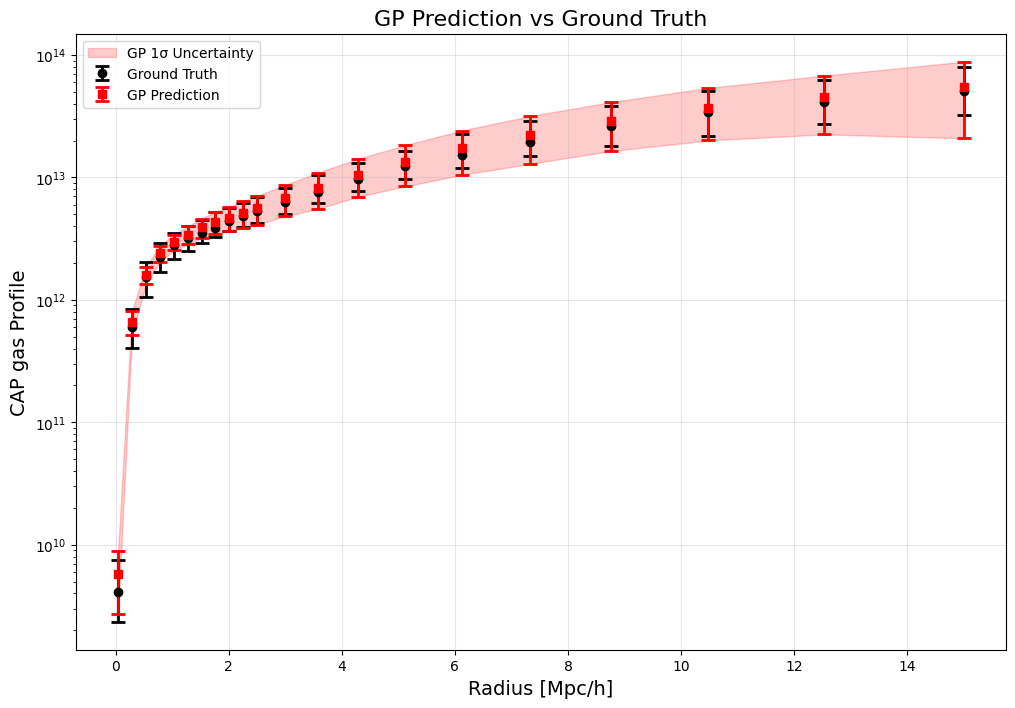

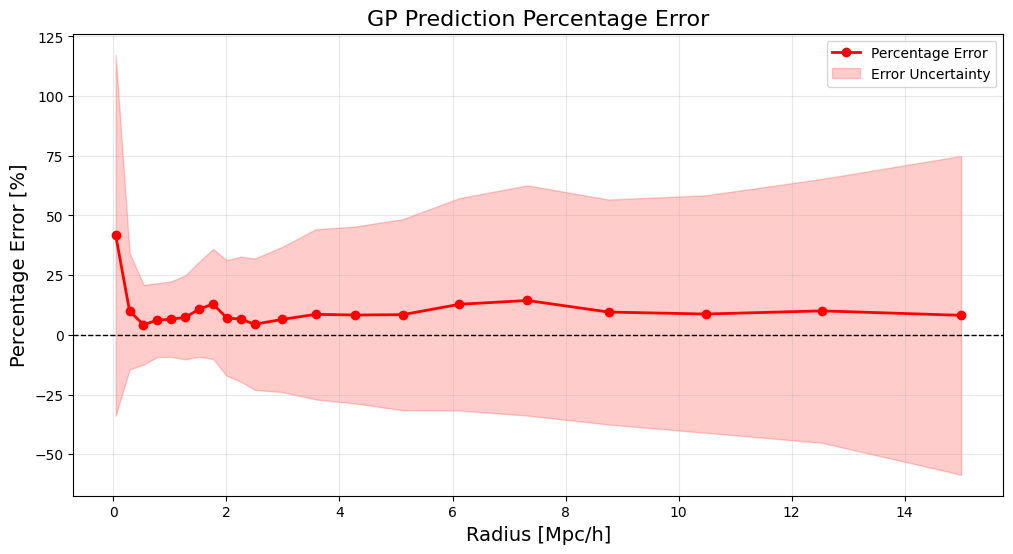

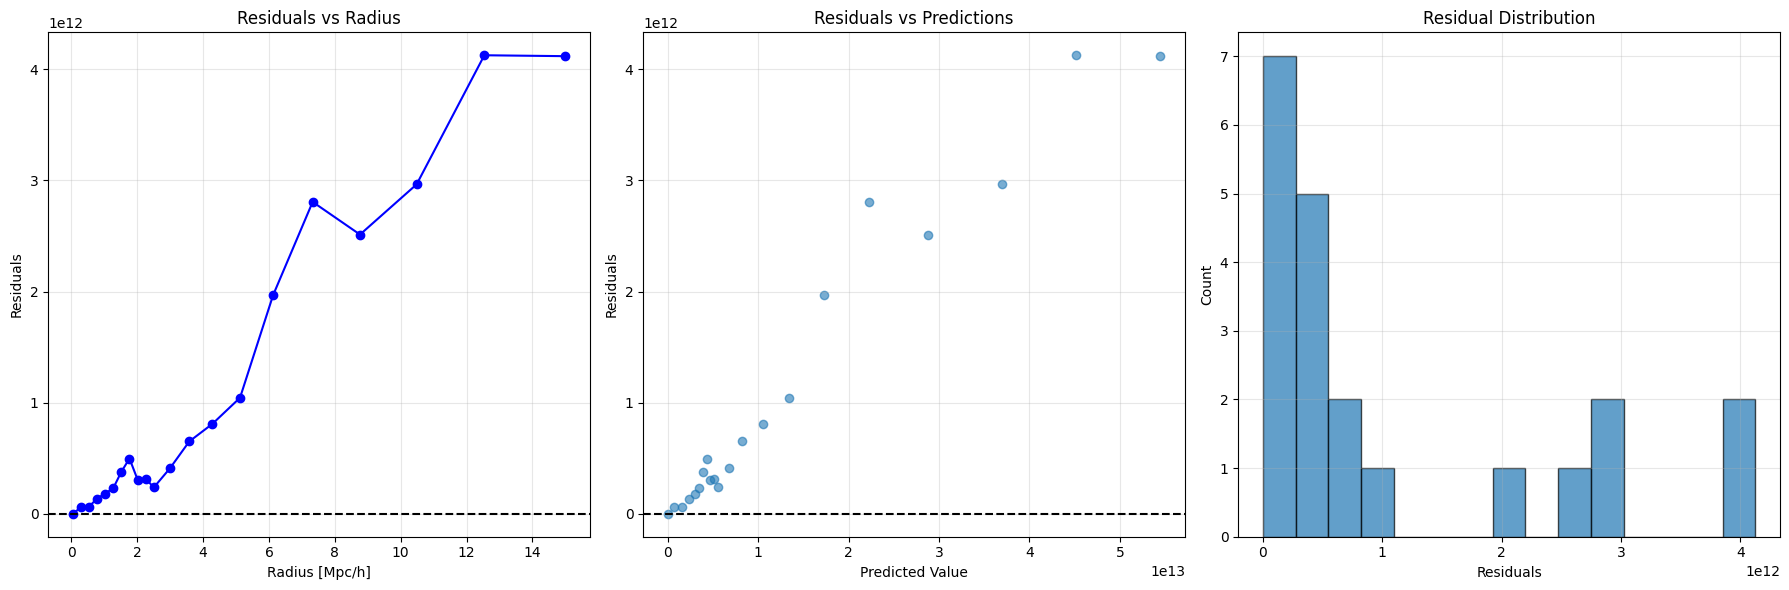


Test Results Summary:
  - MAPE: 10.2%
  - MSE: 3.04e+24
  - High-radius MAPE: 10.2%


{'mse': 3.0431795459661953e+24,
 'mae': 1135012478976.0,
 'mape': 10.15586256980896,
 'r2': 0.9842575211077929,
 'high_radius_mape': 10.178487002849579,
 'n_valid_bins': 21}

In [2]:
# Train GP models
trainer.train(kernel_type='physics_informed', maxiter=1000, plot=True)
#trainer._load_pretrained('/pscratch/sd/l/lindajin/DH_profile_kSZ_WL/trained_gp_models/GPTrainer_090925_1822_CAP_gas/')
# Evaluate on test set
trainer.test(plot=True)

In [19]:
tuning_results = trainer.tune_hyperparameters(
      subset_ratio=0.1,  # 10% of data
      lr_candidates=[1e-4, 3e-4, 1e-3, 3e-3],
      kernel_types=['hierarchical', 'robust', 'physics_informed'],
      max_iter_tune=500,
      n_radius_bins_tune=5
  )

  # Get best config and train full model
best_config = tuning_results['best_config']


🔍 Starting hyperparameter tuning...
  - Subset ratio: 10.0% (71 samples)
  - Testing 4 learning rates × 3 kernels
  - Max iterations per run: 500
  - Early stopping patience: 50
  - Radius bins for tuning: 5

  Testing hierarchical kernel with lr=1e-04
    ❌ Failed: 'ConditionResult' object has no attribute 'predict'

  Testing hierarchical kernel with lr=3e-04
    ❌ Failed: 'ConditionResult' object has no attribute 'predict'

  Testing hierarchical kernel with lr=1e-03
    ❌ Failed: 'ConditionResult' object has no attribute 'predict'

  Testing hierarchical kernel with lr=3e-03
    ❌ Failed: 'ConditionResult' object has no attribute 'predict'

  Testing robust kernel with lr=1e-04
    ❌ Failed: 'ConditionResult' object has no attribute 'predict'

  Testing robust kernel with lr=3e-04
    ❌ Failed: 'ConditionResult' object has no attribute 'predict'

  Testing robust kernel with lr=1e-03
    ❌ Failed: 'ConditionResult' object has no attribute 'predict'

  Testing robust kernel with lr

RuntimeError: All hyperparameter combinations failed!

Loading data for 1 simulations...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21) vs individual halo shape would be (n_halos*1, 21)
Raw data loaded:
  - Profiles: (1, 21)
  - Masses: (1,)
  - Params: (1, 35)
  - PkRatio: (1, 79)
Applying data transformations...
Log mass range: [13.58, 13.58]
✅ Features normalized (zero mean, unit variance)
Final data shapes:
  - Features: (1, 115)
  - Targets: (1, 21)
Creating train/validation/test splits...
Split created:
  - Train: 0 samples (0.0%)
  - Val:   0 samples (0.0%)
  - Test:  1 samples (100.0%)
✅ DataLoader initialized:
  - Dataset size: 1 samples, 115 features
  - Train/Val/Test: 0/0/1
  - Batch size: 128
{'mse': 3.2821210289980084e+25, 'mae': 3810519678976.0, 'mape': 72.54825830459595, 'r2': 0.7050473093986511, 'high_radius_mape': 29.95622754096985, 'n_valid_bins': 21}


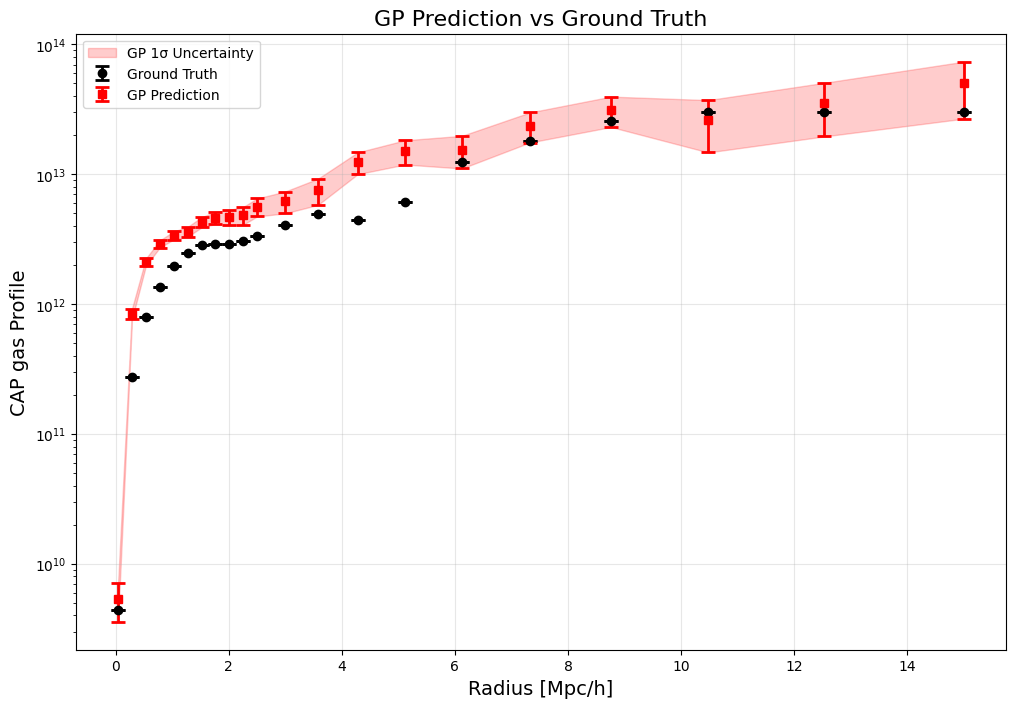

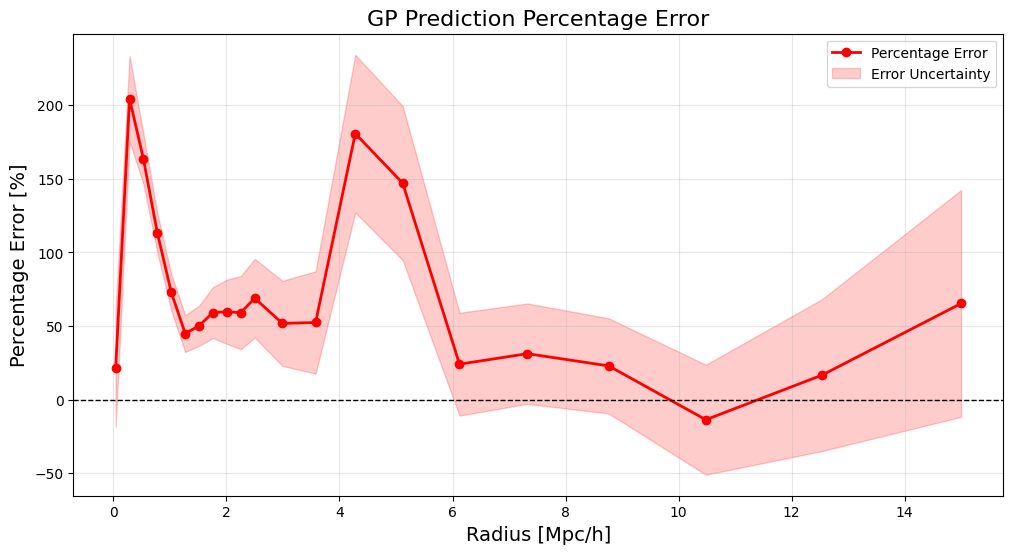

In [6]:
sim_indices_test = [777] #np.load('data/sparse_sampling_test_indices_random.npy')[:20]  # Use subset for testing
importlib.reload(src.data.sim_dataloader) 
from src.data.sim_dataloader import create_gp_dataloader
dl_test= create_gp_dataloader(sim_indices_test,  filterType='CAP',
    ptype='gas')
# Predict on new data
pred_means, pred_vars = trainer.pred(dl_test.X)
metrics = trainer._compute_metrics(pred_means, pred_vars, dl_test.y.T)
print(metrics)
 # Compute statistics for plotting

pred_median = np.mean(pred_means, axis=1)
pred_std = np.mean(np.sqrt(pred_vars), axis=1)
y_test_T = dl_test.y.T

true_median = np.median(y_test_T, axis=1)
true_lower = np.quantile(y_test_T, 0.25, axis=1)
true_upper = np.quantile(y_test_T, 0.75, axis=1)

# 1. Profile comparison plot
plt.figure(figsize=(12, 8))

# Plot ground truth
plt.errorbar(dl_test.r_bins, true_median, 
            yerr=[true_median - true_lower, true_upper - true_median],
            fmt='o', capsize=5, capthick=2, linewidth=2, markersize=6, 
            color='black', label='Ground Truth')

# Plot predictions
plt.errorbar(trainer.r_bins, pred_median, yerr=pred_std,
            fmt='s', capsize=5, capthick=2, linewidth=2, markersize=6,
            color='red', label='GP Prediction')

plt.fill_between(trainer.r_bins, pred_median - pred_std, pred_median + pred_std,
                color='red', alpha=0.2, label='GP 1σ Uncertainty')

plt.yscale('log')
plt.xlabel('Radius [Mpc/h]', fontsize=14)
plt.ylabel(f'{trainer.filterType} {trainer.ptype} Profile', fontsize=14)
plt.title(f'GP Prediction vs Ground Truth', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(trainer.save_dir+f'test_{sim_indices_test[0]}_{trainer.filterType}_{trainer.ptype}.png')

plt.figure(figsize=(12, 6))

percent_error = 100 * (pred_median - true_median) / true_median
error_std = 100 * pred_std / true_median

plt.plot(trainer.r_bins, percent_error, 'ro-', linewidth=2, markersize=6, 
        label='Percentage Error')
plt.fill_between(trainer.r_bins, percent_error - error_std, percent_error + error_std,
                color='red', alpha=0.2, label='Error Uncertainty')

plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Radius [Mpc/h]', fontsize=14)
plt.ylabel('Percentage Error [%]', fontsize=14)
plt.title('GP Prediction Percentage Error', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)


=== Testing GP Models ===
Evaluating on test set...
Generating predictions...


Predicting: 100%|██████████| 21/21 [00:02<00:00,  8.26it/s]


Predictions generated in 2.5s


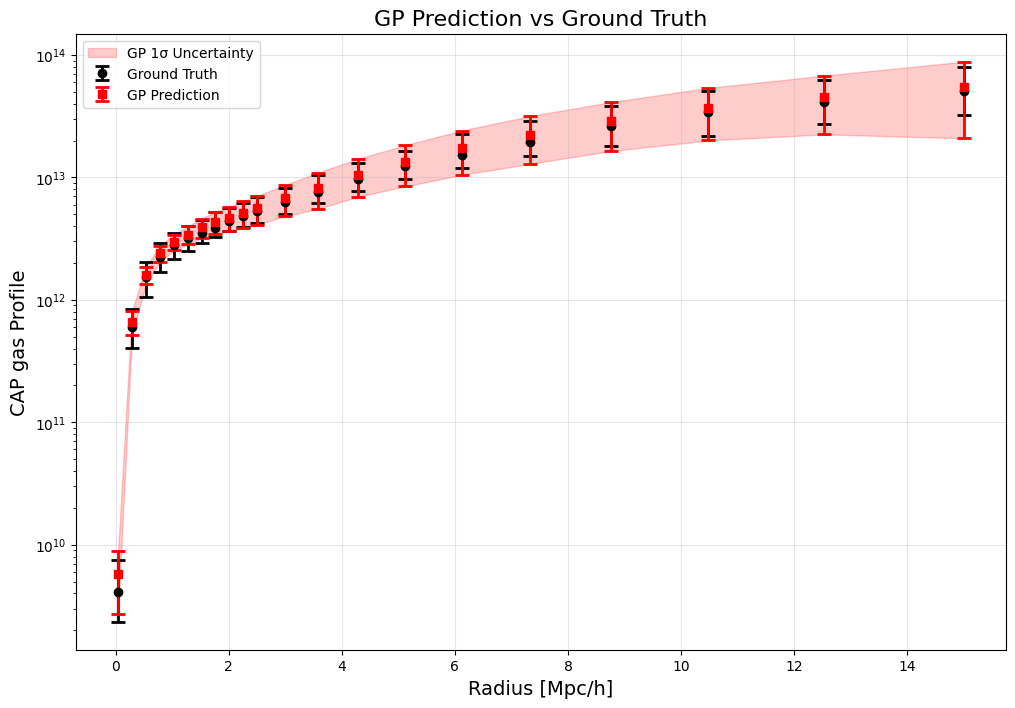

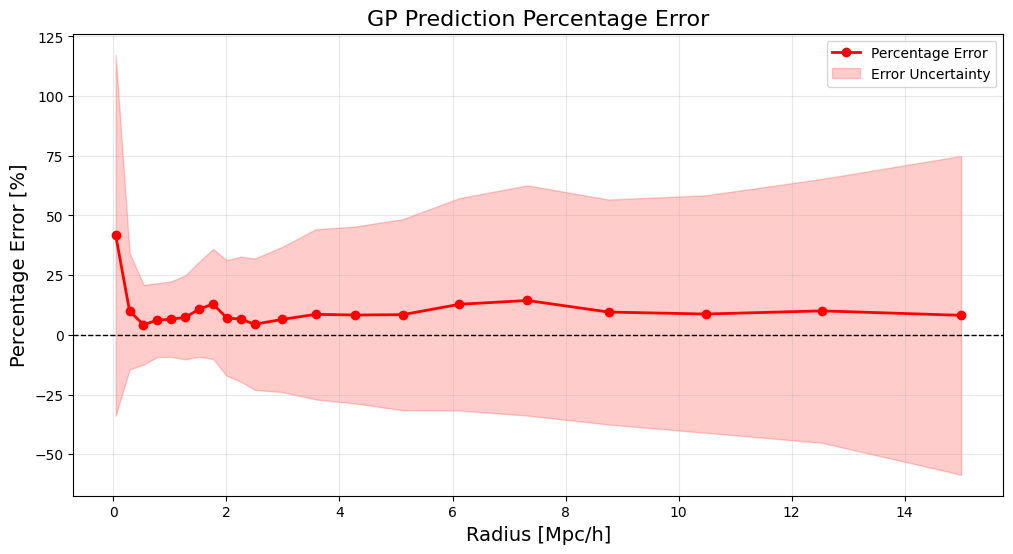

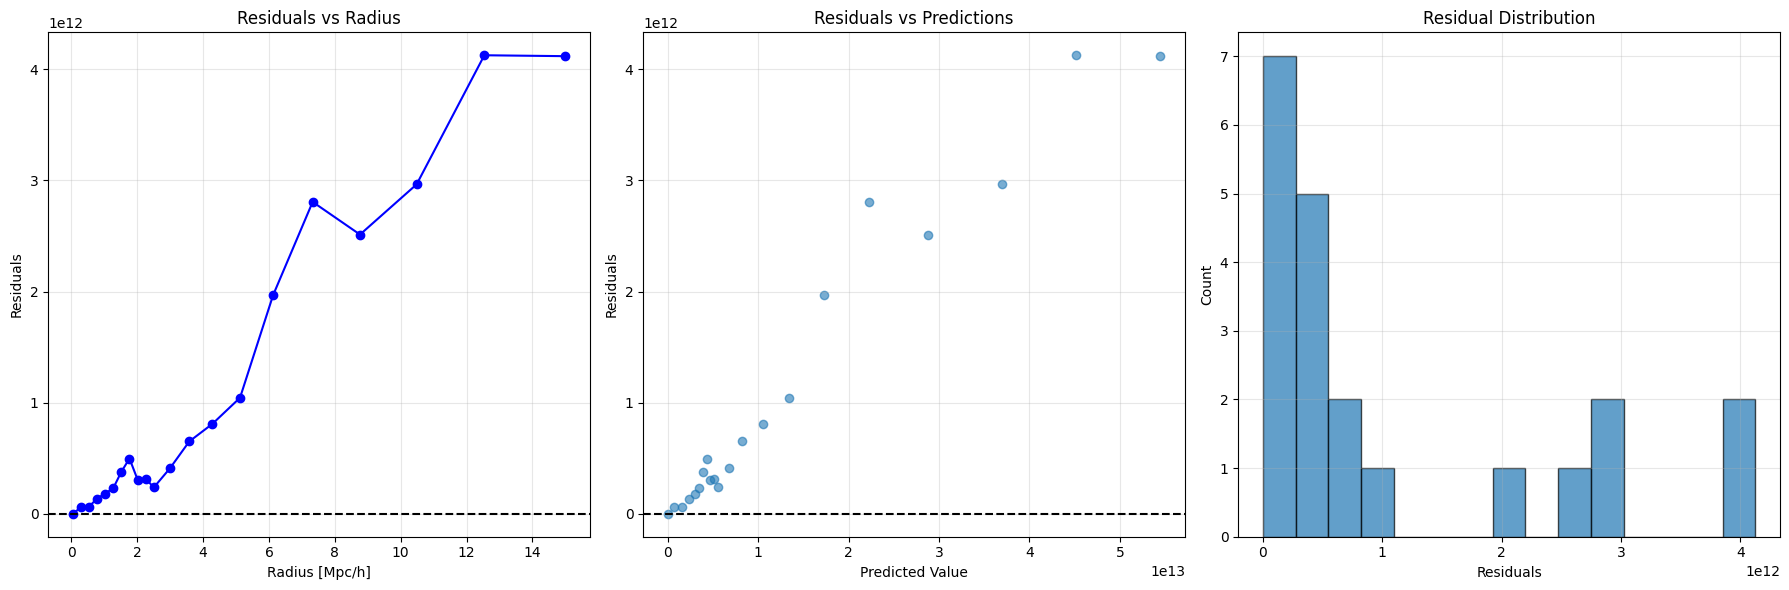


Test Results Summary:
  - MAPE: 10.2%
  - MSE: 3.04e+24
  - High-radius MAPE: 10.2%


{'mse': 3.0431795459661953e+24,
 'mae': 1135012478976.0,
 'mape': 10.15586256980896,
 'r2': 0.9842575211077929,
 'high_radius_mape': 10.178487002849579,
 'n_valid_bins': 21}

In [22]:
trainer.test(plot=True)